# Single Sample Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>)
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 24.07.2024

Run this notebook in the nichecompass-reproducibility environment, installable from ```('../../../envs/environment.yaml')```.

Before running this notebook:
- Clone SDMBench from https://github.com/zhaofangyuan98/SDMBench/tree/main/SDMBench into ```('../benchmarking')``` (some slight modifications to the SDMBench source code were necessary to remove technical bugs).
- Compute the single sample method benchmarking metrics by triggering the respective jobs (under **Single Sample Method Benchmarking** header) in ```('../../slurm_job_submission.ipynb')```.


## 1. Setup

### 1.1 Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../../../utils")

In [ ]:
import gc
import os
import shutil
import warnings
from datetime import datetime

import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plottable
import scanpy as sc
import seaborn as sns
#from cellcharter.tl import Cluster
from scipy.spatial.distance import pdist
from nichecompass.models import NicheCompass

from benchmarking_utils import *

### 1.2 Define Parameters

In [ ]:
metric_cols_single_sample = [
    "cas", "mlami", # global spatial consistency
    "clisis", "gcs", # local spatial consistency
    "nasw", "cnmi", # niche coherence
]
metric_col_weights_single_sample = [ # separate for each category (later multiplied with category_col_weights)
    (1/8), (1/8), # global spatial consistency
    (1/8), (1/8), # local spatial consistency
    (1/4), (1/4), # niche clustering performance
]
metric_col_titles_single_sample = [
    "CAS", # "Cell Type Affinity Similarity",
    "MLAMI", # "Maximum Leiden Adjusted Mutual Info",
    "CLISIS", # "Cell Type Local Inverse Simpson's Index Similarity",
    "GCS", # "Graph Connectivity Similarity",
    "NASW", # "Niche Average Silhouette Width",
    "CNMI", # "Cell Type Normalized Mutual Info",
]

category_cols_single_sample = [
    "Global Spatial Consistency Score",
    "Local Spatial Consistency Score",
    "Niche Coherence Score"]
category_col_weights_single_sample = [
    0.25,
    0.25,
    0.5]
category_col_titles_single_sample = [
    "Global Spatial Consistency Score",
    "Local Spatial Consistency Score",
    "Niche Coherence Score"]

In [ ]:
# Define ground truth niche prediction metrics
sdm_bench_metric_cols = ["sdmbench_ari",
                         "sdmbench_nmi",
                         "sdmbench_hom",
                         "sdmbench_com"
                        ]

sdm_bench_metric_col_titles = ["NARI",
                               "NNMI",
                               "HOM",
                               "COM"
                              ]

sdm_bench_metric_col_weights = [0.5,
                                0.5,
                                0.5,
                                0.5
                               ]

### 1.3 Run Notebook Setup

In [ ]:
sc.set_figure_params(figsize=(6, 6))

In [ ]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [ ]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [ ]:
data_folder_path = "../../../datasets/st_data/gold"
artifact_folder_path = f"../../../artifacts"
benchmarking_folder_path = f"{artifact_folder_path}/single_sample_method_benchmarking"

## 2. Method Benchmarking Evaluation

- Run all model notebooks in this directory (```./```) before continuing.

### 2.1 Retrieve NicheCompass Runs

#### 2.1.1 seqFISH Mouse Organogenesis

#### 2.1.2 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

#### 2.1.3 Vizgen MERFISH Mouse Liver

#### 2.1.4 Slide-seqV2 Mouse Hippocampus

#### 2.1.5 Simulation Data

In [ ]:
# Store NicheCompass GCN encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gcnconv"
datasets = [
    "sim1_1105genes_10000locs_strongincrements"
]
timestamps = [
    "26072024_145309_1"
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

# Add niche types
adata = sc.read_h5ad(f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")
adata_original = sc.read_h5ad(f"{data_folder_path}/{dataset}.h5ad")
adata.obs["niche_type"] = adata_original.obs["niche_types"]
adata.write(f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")

In [ ]:
# Store NicheCompass GCN encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gatv2conv"
datasets = [
    "sim1_1105genes_10000locs_strongincrements"
]
timestamps = [
    "26072024_145319_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

# Add niche types
adata = sc.read_h5ad(f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")
adata_original = sc.read_h5ad(f"{data_folder_path}/{dataset}.h5ad")
adata.obs["niche_type"] = adata_original.obs["niche_types"]
adata.write(f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")

#### 2.1.6 SDMBench Data

In [ ]:
# Store NicheCompass GCN encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gcnconv"
datasets = [
    "starmap_mouse_mpfc"
]
timestamps = [
    "26072024_145312_1",
    #"26072024_095208_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

# Add niche types
adata = sc.read_h5ad(f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")
adata_original = sc.read_h5ad(f"{data_folder_path}/{dataset}.h5ad")
adata.obs["niche_type"] = adata_original.obs["niche_type"]
adata.write(f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")

In [ ]:
# Store NicheCompass GCN encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gatv2conv"
datasets = [
    "starmap_mouse_mpfc"
]
timestamps = [
    "26072024_145309_1",
    #"26072024_095208_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

# Add niche types
adata = sc.read_h5ad(f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")
adata_original = sc.read_h5ad(f"{data_folder_path}/{dataset}.h5ad")
adata.obs["niche_type"] = adata_original.obs["niche_type"]
adata.write(f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")

In [ ]:
# Store NicheCompass GCN encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gcnconv"
datasets = [
    "stereoseq_mouse_embryo"
]
timestamps = [
    "26072024_145308_1"
    #"26072024_122156_1"
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

# Add niche types
adata = sc.read_h5ad(f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")
adata_original = sc.read_h5ad(f"{data_folder_path}/{dataset}.h5ad")
adata.obs["niche_type"] = adata_original.obs["niche_type"]
adata.write(f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")

In [ ]:
# Store NicheCompass GCN encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gatv2conv"
datasets = [
    "stereoseq_mouse_embryo"
]
timestamps = [
    "26072024_151239_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

# Add niche types
adata = sc.read_h5ad(f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")
adata_original = sc.read_h5ad(f"{data_folder_path}/{dataset}.h5ad")
adata.obs["niche_type"] = adata_original.obs["niche_type"]
adata.write(f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")

### 2.1 Create Benchmarking Plots

#### 2.1.1 Slide-seqV2 Mouse Hippocampus

In [ ]:
### Supplementary fig. 12e: spatial clusters ###
adata = sc.read_h5ad(f"{data_folder_path}/slideseqv2_mouse_hippocampus.h5ad")
adata.obs["sample"] = "sample1"

leiden_resolution = 0.1

print("\nComputing neighbor graph...")
sc.pp.neighbors(adata,
                use_rep="spatial",
                key_added="spatial_knn")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key="spatial_knn")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=leiden_resolution,
             key_added=f"spatial_leiden_{leiden_resolution}",
             neighbors_key="spatial_knn")

spatial_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"spatial_leiden_{leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Spatial Clusters",
        model_label=None,
        cat_key=f"spatial_leiden_{leiden_resolution}",
        groups=None,
        sample_key="sample",
        samples=["sample1"], # =None for latent UMAP
        cat_colors=spatial_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=30,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/spatial_clusters.svg")

In [ ]:
### Fig. 3d: metrics ###
datasets = ["slideseqv2_mouse_hippocampus"]
models = [#"nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          #"staci", # did not run
          "graphst",
          "deeplinc",
          "cellcharter",
          "banksy"
]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_single_sample)):
        min_val = dataset_df[metric_cols_single_sample[i]].min()
        max_val = dataset_df[metric_cols_single_sample[i]].max()
        dataset_df[metric_cols_single_sample[i] + "_scaled"] = ((
            dataset_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
    
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[4:6]]
    
summary_df[category_cols_single_sample[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[0:2],
                                                        axis=1)
summary_df[category_cols_single_sample[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[2:4],
                                                        axis=1)
summary_df[category_cols_single_sample[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[4:6],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]],
                                         weights=category_col_weights_single_sample[:3],
                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    #"nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "cellcharter": "CellCharter",
                    "banksy": "BANKSY"},
                   inplace=True)

# Filter for just second run
summary_df = summary_df[summary_df["run_number"] == 2]

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample + ["Overall Score"]].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_single_sample + ["Overall Score"],
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass", "STACI", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

unrolled_df["model"] = unrolled_df["model"].replace("NicheCompass GATv2", "NicheCompass")
#unrolled_df["model"] = unrolled_df["model"].replace("NicheCompass GCN", "NicheCompass Light")

# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.6,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample], # category_col_titles_single_sample
    metric_col_width=0.7, # 0.8,
    aggregate_col_width=1.2,
    plot_width=8, # 8.5, # 32,
    plot_height=7,# 8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_slideseqv2_mouse_hippocampus_run2.svg")

In [ ]:
### Supplementary fig. 13b: 25% subsample metrics ###
datasets = ["slideseqv2_mouse_hippocampus_subsample_25pct"]
models = [#"nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "staci",
          "graphst",
          "deeplinc",
          "cellcharter",
          "banksy"
]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = dataset_df.append(missing_run_df, ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_single_sample)):
        min_val = dataset_df[metric_cols_single_sample[i]].min()
        max_val = dataset_df[metric_cols_single_sample[i]].max()
        dataset_df[metric_cols_single_sample[i] + "_scaled"] = ((
            dataset_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
    
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[4:6]]
    
summary_df[category_cols_single_sample[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[0:2],
                                                        axis=1)
summary_df[category_cols_single_sample[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[2:4],
                                                        axis=1)
summary_df[category_cols_single_sample[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[4:6],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]],
                                         weights=category_col_weights_single_sample[:3],
                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "cellcharter": "CellCharter",
                    "banksy": "BANKSY"}, inplace=True)

# Filter for just second run
summary_df = summary_df[summary_df["run_number"] == 2]

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample + ["Overall Score"]].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_single_sample + ["Overall Score"],
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass", "STACI", "DeepLinc", "GraphST", "CellCharter"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

unrolled_df["model"] = unrolled_df["model"].replace("NicheCompass GATv2", "NicheCompass")
#unrolled_df["model"] = unrolled_df["model"].replace("NicheCompass GCN", "Mini NicheCompass")

# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.6,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample], # category_col_titles_single_sample
    metric_col_width=0.8, # 0.8,
    aggregate_col_width=1.2,
    plot_width=8.5, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_slideseqv2_mouse_hippocampus_subsample_25pct_run2.svg")

In [ ]:
### Fig. 3a: NicheCompass niches ###
dataset = "slideseqv2_mouse_hippocampus"
models = ["nichecompass_gatv2conv"]
run_number = 2
leiden_resolutions = [0.35]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    sc.tl.leiden(adata=adata,
                 resolution=0.125,
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[0]}",
                 restrict_to=(f"run{run_number}_leiden_{leiden_resolutions[0]}", ["7"]),
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    sc.tl.leiden(adata=adata,
                 resolution=0.125,
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[0]}",
                 restrict_to=(f"run{run_number}_leiden_{leiden_resolutions[0]}", ["7,1"]),
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    niche_annotations = {
        "0": "Stratum",
        "1": "Thalamus LD",
        "2": "Cortical layer 5",
        "3": "Thalamus LP", 
        "4": "Cortical layer 6b",
        "5": "Corpus callosum",
        "6": "Cortical layer 6a",
        "7,0": "CA1",
        "7,1,0": "CA1",
        "7,1,1": "Fasciola cinerea (FC)",
        "8": "CA2 & CA3",
        "9": "Dentate gyrus",
        "10": "Medial habenula (MH)",
        "11": "Lateral habenula (LH)",
        "12": "Cortical layer 2/3",
        "13": "Third Ventricle (V3)"}

    adata.obs["niche"] = adata.obs[f"run{run_number}_leiden_{leiden_resolutions[0]}"].map(niche_annotations)

    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}")
    
    niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotations.items()}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            #figsize=(10, 20), for latent UMAP
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"niche",
            groups=None,
            sample_key="sample",
            samples=["sample1"], # =None for latent UMAP
            cat_colors=niche_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
### Fig. 3b: NicheCompass tissue niche hierarchy & composition ###
model = "nichecompass"
run_number = 2

sc.tl.dendrogram(adata=adata,
                 use_rep=f"{model}_latent_run{run_number}",
                 linkage_method="ward",
                 groupby="niche")

fig, (ax) = plt.subplots(1, 1, figsize=(2, 5))
sc.pl.dendrogram(
    adata=adata,
    groupby="niche",
    orientation="left",
    show=False,
    save=f"_{dataset}_{model}_run{run_number}",
    ax=ax)
plt.show()
if os.path.exists(benchmarking_folder_path + f"/dendrogram_{dataset}_{model}_run{run_number}.pdf"):
    os.remove(benchmarking_folder_path + f"/dendrogram_{dataset}_{model}_run{run_number}.pdf")
shutil.move(f"./figures/dendrogram_{dataset}_{model}_run{run_number}.pdf", benchmarking_folder_path)
shutil.rmtree("./figures/")

cell_type_colors = create_new_color_dict(
    adata=adata,
    color_palette="cell_type_30",
    cat_key="cell_type")

tmp = pd.crosstab(adata.obs["niche"], adata.obs["cell_type"], normalize='index')
tmp = tmp.reindex(adata.uns["dendrogram_niche"]["categories_ordered"][::])
ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 10)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.xlabel("Cell Type Proportions", fontsize=24)
plt.savefig(f"{benchmarking_folder_path}/niche_cell_type_proportions_{model}.svg", bbox_inches='tight')

# Compute cluster centroids for cortical layer niches
embeddings = adata.obsm[f"{model}_latent_run{run_number}"]
cluster_labels = adata.obs["niche"]
embeddings_df = pd.DataFrame(embeddings, index=adata.obs_names)
embeddings_df['cluster_labels'] = cluster_labels.values
centroids = embeddings_df.groupby('cluster_labels').mean()
cortical_layers_centroids = centroids[centroids.index.str.contains("Cortical")]

# Compute average pairwise distance between centroids
pairwise_distances = pdist(cortical_layers_centroids.to_numpy(), metric='euclidean')
average_distance = np.mean(pairwise_distances)
print(average_distance)

In [ ]:
### Fig. 3c: GraphST niches ###
dataset = "slideseqv2_mouse_hippocampus"
models = ["graphst"]
run_number = 2
leiden_resolutions = [0.93]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    sc.tl.leiden(adata=adata,
                 resolution=0.4,
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[0]}",
                 restrict_to=(f"run{run_number}_leiden_{leiden_resolutions[0]}", ["0"]),
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    sc.tl.leiden(adata=adata,
                 resolution=0.1,
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[0]}",
                 restrict_to=(f"run{run_number}_leiden_{leiden_resolutions[0]}", ["7"]),
                 neighbors_key=f"{model}_latent_run{run_number}")

    niche_annotations = {
        "0,0": "Cortical layer 2/3",
        "0,1": "Cortical layer 5",
        "0,2": "Cortical layer 6a",
        "1": "Stratum",
        "2": "Thalamus LD",
        "3": "Corpus callosum",
        "4": "Cortical layer 6b",
        "5": "Thalamus LP",
        "6": "CA1",
        "7,0": "CA3",
        "7,1": "Fasciola cinerea (FC) & CA2",
        "8": "Dentate gyrus",
        "9": "Artifact 1",
        "10": "Third Ventricle (V3)",
        "11": "Medial habenula (MH)",
        "12": "Lateral habenula (LH)",
        "13": "Artifact 2"}

    adata.obs["niche"] = adata.obs[f"run{run_number}_leiden_0.93"].map(niche_annotations)

    niche_colors = {            
        'Stratum': '#8BE0A4',
        'Thalamus LD': '#F6CF71',
        'Cortical layer 6b': '#B497E7',
        'Thalamus LP': '#87C55F',
        'Corpus callosum': '#9D88A2',
        'Cortical layer 5': '#9EB9F3',
        'CA1': '#C38D9E',
        'CA3': '#DCB0F2',
        'Dentate gyrus': '#D3B484',
        'Medial habenula (MH)': '#F89C74',
        'Lateral habenula (LH)': '#C9DB74',
        'Third Ventricle (V3)': '#B3B3B3',
        'Cortical layer 2/3': '#DAB6C4',
        'Cortical layer 6a': "#66C5CC",
        'Fasciola cinerea (FC) & CA2': "#276A8C",
        'Artifact 1': "#FF4D4D",
        'Artifact 2': "#D2691E"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            figsize=(10, 20), #for latent UMAP
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"niche",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=niche_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
### Fig. 3c: GraphST tissue niche hierarchy ###
model = "graphst"
run_number = 2

sc.tl.dendrogram(adata=adata,
                 use_rep=f"{model}_latent_run{run_number}",
                 linkage_method="ward",
                 groupby="niche")

fig, (ax) = plt.subplots(1, 1, figsize=(2, 5))
sc.pl.dendrogram(
    adata=adata,
    groupby="niche",
    orientation="left",
    show=False,
    save=f"_{dataset}_{model}_run{run_number}",
    ax=ax)
plt.show()
if os.path.exists(benchmarking_folder_path + f"/dendrogram_{dataset}_{model}_run{run_number}.pdf"):
    os.remove(benchmarking_folder_path + f"/dendrogram_{dataset}_{model}_run{run_number}.pdf")
shutil.move(f"./figures/dendrogram_{dataset}_{model}_run{run_number}.pdf", benchmarking_folder_path)
shutil.rmtree("./figures/")

cell_type_colors = create_new_color_dict(
    adata=adata,
    color_palette="cell_type_30",
    cat_key="cell_type")

tmp = pd.crosstab(adata.obs["niche"], adata.obs["cell_type"], normalize='index')
tmp = tmp.reindex(adata.uns["dendrogram_niche"]["categories_ordered"][::])
ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 10)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.xlabel("Cell Type Proportions", fontsize=24)
plt.savefig(f"{benchmarking_folder_path}/niche_cell_type_proportions_{model}.svg", bbox_inches='tight')

# Compute cluster centroids for cortical layer niches
embeddings = adata.obsm[f"{model}_latent_run{run_number}"]
cluster_labels = adata.obs["niche"]
embeddings_df = pd.DataFrame(embeddings, index=adata.obs_names)
embeddings_df['cluster_labels'] = cluster_labels.values
centroids = embeddings_df.groupby('cluster_labels').mean()
cortical_layers_centroids = centroids[centroids.index.str.contains("Cortical")]

# Compute average pairwise distance between centroids
pairwise_distances = pdist(cortical_layers_centroids.to_numpy(), metric='euclidean')
average_distance = np.mean(pairwise_distances)
print(average_distance)

In [ ]:
### Fig. 3c: CellCharter niches ###
dataset = "slideseqv2_mouse_hippocampus"
models = ["cellcharter"]
run_number = 2
leiden_resolutions = [0.8]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")
    
    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")

    # Use cellcharter clustering
    #gmm = Cluster(
    #    n_clusters=12, 
    #    random_state=0,
    #    # If running on GPU
    #    #trainer_params=dict(accelerator='gpu', devices=1)
    #)
    #gmm.fit(adata, use_rep=f"{model}_latent_run{run_number}")
    #adata.obs["spatial_clusters"] = gmm.predict(adata, use_rep=f"{model}_latent_run{run_number}").astype("str")
    
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    sc.tl.leiden(adata=adata,
                 resolution=0.3,
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 restrict_to=(f"run{run_number}_leiden_{leiden_resolutions[i]}", ["0"]),
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    sc.tl.leiden(adata=adata,
                 resolution=0.05,
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 restrict_to=(f"run{run_number}_leiden_{leiden_resolutions[i]}", ["12"]),
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    niche_annotations = {
        "0,0": "Cortical layer 5",
        "0,1": "Cortical layer 6a",
        "1": "Thalamus LD",
        "2": "Stratum",
        "3": "Thalamus LP",
        "4": "CA1",
        "5": "Corpus callosum", # "Artifact 1",
        "6": "Cortical layer 6b",
        "7": "CA2 & CA3",
        "8": "Dentate gyrus",
        "9": "Lateral habenula (LH)",
        "10": "Medial habenula (MH)",
        "11": "Cortical layer 2/3",
        "12,0": "Third Ventricle (V3)",
        "12,1": "Fasciola cinerea (FC)",
        "13": "Artifact 3",
        "14": "Artifact 1",
        "15": "Artifact 2"}

    adata.obs["niche"] = adata.obs[f"run{run_number}_leiden_{leiden_resolutions[i]}"].map(niche_annotations)

    niche_colors = {            
        'Stratum': '#8BE0A4',
        'Thalamus LD': '#F6CF71',
        'Cortical layer 6b': '#B497E7',
        'Thalamus LP': '#87C55F',
        'Corpus callosum': '#9D88A2',
        'Cortical layer 5': '#9EB9F3',
        'CA1': '#C38D9E',
        'CA2 & CA3': '#DCB0F2',
        'Dentate gyrus': '#D3B484',
        'Medial habenula (MH)': '#F89C74',
        'Lateral habenula (LH)': '#C9DB74',
        'Third Ventricle (V3)': '#B3B3B3',
        'Cortical layer 2/3': '#DAB6C4',
        'Cortical layer 6a': "#66C5CC",
        'Fasciola cinerea (FC)': "#276A8C",
        'Artifact 1': "#FF4D4D",
        'Artifact 2': "#D2691E",
        'Artifact 3': "#D2121E"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            figsize=(10, 20), #for latent UMAP
            plot_label="Latent Clusters",
            model_label=model,
            cat_key="niche",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=niche_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
### Fig. 3c: Cellcharter tissue niche hierarchy ###
model = "cellcharter"
run_number = 2

sc.tl.dendrogram(adata=adata,
                 use_rep=f"{model}_latent_run{run_number}",
                 linkage_method="ward",
                 groupby="niche")

fig, (ax) = plt.subplots(1, 1, figsize=(2, 5))
sc.pl.dendrogram(
    adata=adata,
    groupby="niche",
    orientation="left",
    show=False,
    save=f"_{dataset}_{model}_run{run_number}",
    ax=ax)
plt.show()
if os.path.exists(benchmarking_folder_path + f"/dendrogram_{dataset}_{model}_run{run_number}.pdf"):
    os.remove(benchmarking_folder_path + f"/dendrogram_{dataset}_{model}_run{run_number}.pdf")
shutil.move(f"./figures/dendrogram_{dataset}_{model}_run{run_number}.pdf", benchmarking_folder_path)
shutil.rmtree("./figures/")

cell_type_colors = create_new_color_dict(
    adata=adata,
    color_palette="cell_type_30",
    cat_key="cell_type")

tmp = pd.crosstab(adata.obs["niche"], adata.obs["cell_type"], normalize='index')
tmp = tmp.reindex(adata.uns["dendrogram_niche"]["categories_ordered"][::])
ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 10)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.xlabel("Cell Type Proportions", fontsize=24)
plt.savefig(f"{benchmarking_folder_path}/niche_cell_type_proportions_{model}.svg", bbox_inches='tight')

# Compute cluster centroids for cortical layer niches
embeddings = adata.obsm[f"{model}_latent_run{run_number}"]
cluster_labels = adata.obs["niche"]
embeddings_df = pd.DataFrame(embeddings, index=adata.obs_names)
embeddings_df['cluster_labels'] = cluster_labels.values
centroids = embeddings_df.groupby('cluster_labels').mean()
cortical_layers_centroids = centroids[centroids.index.str.contains("Cortical")]

# Compute average pairwise distance between centroids
pairwise_distances = pdist(cortical_layers_centroids.to_numpy(), metric='euclidean')
average_distance = np.mean(pairwise_distances)
print(average_distance)

In [ ]:
### Fig. 3c: BANKSY niches ###
dataset = "slideseqv2_mouse_hippocampus"
models = ["banksy"]
run_number = 2
leiden_resolutions = [0.35]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")
    
    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
    
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    sc.tl.leiden(adata=adata,
                 resolution=0.2,
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[0]}",
                 restrict_to=(f"run{run_number}_leiden_{leiden_resolutions[0]}", ["0"]),
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    sc.tl.leiden(adata=adata,
                 resolution=0.15,
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[0]}",
                 restrict_to=(f"run{run_number}_leiden_{leiden_resolutions[0]}", ["1"]),
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    sc.tl.leiden(adata=adata,
                 resolution=0.05,
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[0]}",
                 restrict_to=(f"run{run_number}_leiden_{leiden_resolutions[0]}", ["4"]),
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    niche_annotations = {
        "0,0": "Cortical layer 6b",
        "0,1": "Cortical layer 5",
        "0,2": "Cortical layer 6a",
        "1,0": "Thalamus LD",
        "1,1": "Thalamus LP",
        "1,2": "Artifact 2",
        "2": "Stratum",
        "3": "Corpus callosum",
        "4,0": "CA2 & CA3",
        "4,1": "Fasciola cinerea (FC)",
        "5": "CA1",
        "6": "Dentate gyrus",
        "7": "Lateral habenula (LH)", #"Artifact 1",
        "8": "Cortical layer 2/3",
        "9": "Third Ventricle (V3)",
        "10": "Artifact 1",
        "11": "Dentate gyrus",
        "12": "Medial habenula (MH)"}

    adata.obs["niche"] = adata.obs[f"run{run_number}_leiden_{leiden_resolutions[i]}"].map(niche_annotations)

    niche_colors = {            
        'Stratum': '#8BE0A4',
        'Thalamus LD': '#F6CF71',
        'Cortical layer 6b': '#B497E7',
        'Thalamus LP': '#87C55F',
        'Corpus callosum': '#9D88A2',
        'Cortical layer 5': '#9EB9F3',
        'CA1': '#C38D9E',
        'CA2 & CA3': '#DCB0F2',
        'Dentate gyrus': '#D3B484',
        'Medial habenula (MH)': '#F89C74',
        'Lateral habenula (LH)': '#C9DB74',
        'Third Ventricle (V3)': '#B3B3B3',
        'Cortical layer 2/3': '#DAB6C4',
        'Cortical layer 6a': "#66C5CC",
        'Fasciola cinerea (FC)': "#276A8C",
        'Artifact 1': "#FF4D4D",
        'Artifact 2': "#D2691E"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            figsize=(10, 20), #for latent UMAP
            plot_label="Latent Clusters",
            model_label={model},
            cat_key="niche",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=niche_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
### Fig. 3c: Banksy tissue niche hierarchy ###
model = "banksy"
run_number = 2

sc.tl.dendrogram(adata=adata,
                 use_rep=f"{model}_latent_run{run_number}",
                 linkage_method="ward",
                 groupby="niche")

fig, (ax) = plt.subplots(1, 1, figsize=(2, 5))
sc.pl.dendrogram(
    adata=adata,
    groupby="niche",
    orientation="left",
    show=False,
    save=f"_{dataset}_{model}_run{run_number}",
    ax=ax)
plt.show()
if os.path.exists(benchmarking_folder_path + f"/dendrogram_{dataset}_{model}_run{run_number}.pdf"):
    os.remove(benchmarking_folder_path + f"/dendrogram_{dataset}_{model}_run{run_number}.pdf")
shutil.move(f"./figures/dendrogram_{dataset}_{model}_run{run_number}.pdf", benchmarking_folder_path)
shutil.rmtree("./figures/")

cell_type_colors = create_new_color_dict(
    adata=adata,
    color_palette="cell_type_30",
    cat_key="cell_type")

tmp = pd.crosstab(adata.obs["niche"], adata.obs["cell_type"], normalize='index')
tmp = tmp.reindex(adata.uns["dendrogram_niche"]["categories_ordered"][::])
ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 10)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.xlabel("Cell Type Proportions", fontsize=24)
plt.savefig(f"{benchmarking_folder_path}/niche_cell_type_proportions_{model}.svg", bbox_inches='tight')

# Compute cluster centroids for cortical layer niches
embeddings = adata.obsm[f"{model}_latent_run{run_number}"]
cluster_labels = adata.obs["niche"]
embeddings_df = pd.DataFrame(embeddings, index=adata.obs_names)
embeddings_df['cluster_labels'] = cluster_labels.values
centroids = embeddings_df.groupby('cluster_labels').mean()
cortical_layers_centroids = centroids[centroids.index.str.contains("Cortical")]

# Compute average pairwise distance between centroids
pairwise_distances = pdist(cortical_layers_centroids.to_numpy(), metric='euclidean')
average_distance = np.mean(pairwise_distances)
print(average_distance)

In [ ]:
### Fig. 3c: DeepLinc niches ###
dataset = "slideseqv2_mouse_hippocampus"
models = ["deeplinc"]
run_number = 2
leiden_resolutions = [1.1]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    sc.tl.leiden(adata=adata,
                 resolution=0.2,
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[0]}",
                 restrict_to=(f"run{run_number}_leiden_{leiden_resolutions[0]}", ["0"]),
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    sc.tl.leiden(adata=adata,
                 resolution=0.125,
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[0]}",
                 restrict_to=(f"run{run_number}_leiden_{leiden_resolutions[0]}", ["8"]),
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    niche_annotations = {
        "0,0": "Cortical layer 6a",
        "0,1": "Cortical layer 5",
        "1": "Thalamus LD",
        "2": "Cortical layer 6b",
        "3": "Thalamus LP",
        "4": "Corpus callosum",
        "5": "Stratum",
        "6": "CA1",
        "7": "Dentate gyrus",
        "8,0": "Lateral habenula (LH)",
        "8,1": "Medial habenula (MH)",
        "9": "CA2 & CA3",
        "10": "Cortical layer 2/3",
        "11": "Third Ventricle (V3)",
        "12": "Artifact 1",
        "13": "Fasciola cinerea (FC)"}

    adata.obs["niche"] = adata.obs[f"run{run_number}_leiden_{leiden_resolutions[0]}"].map(niche_annotations)
    
    niche_colors = {            
        'Stratum': '#8BE0A4',
        'Thalamus LD': '#F6CF71',
        'Cortical layer 6b': '#B497E7',
        'Thalamus LP': '#87C55F',
        'Corpus callosum': '#9D88A2',
        'Cortical layer 5': '#9EB9F3',
        'CA1': '#C38D9E',
        'CA2 & CA3': '#DCB0F2',
        'Dentate gyrus': '#D3B484',
        'Medial habenula (MH)': '#F89C74',
        'Lateral habenula (LH)': '#C9DB74',
        'Third Ventricle (V3)': '#B3B3B3',
        'Cortical layer 2/3': '#DAB6C4',
        'Cortical layer 6a': "#66C5CC",
        'Fasciola cinerea (FC)': "#276A8C",
        'Artifact 1': "#FF4D4D",
        'Artifact 2': "#D2691E"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            figsize=(10, 20), #for latent UMAP
            plot_label="Latent Clusters",
            model_label={model},
            cat_key="niche",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=niche_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
### Fig. 3c: DeepLinc tissue niche hierarchy ###
model = "deeplinc"
run_number = 2

sc.tl.dendrogram(adata=adata,
                 use_rep=f"{model}_latent_run{run_number}",
                 linkage_method="ward",
                 groupby="niche")

fig, (ax) = plt.subplots(1, 1, figsize=(2, 5))
sc.pl.dendrogram(
    adata=adata,
    groupby="niche",
    orientation="left",
    show=False,
    save=f"_{dataset}_{model}_run{run_number}",
    ax=ax)
plt.show()
if os.path.exists(benchmarking_folder_path + f"/dendrogram_{dataset}_{model}_run{run_number}.pdf"):
    os.remove(benchmarking_folder_path + f"/dendrogram_{dataset}_{model}_run{run_number}.pdf")
shutil.move(f"./figures/dendrogram_{dataset}_{model}_run{run_number}.pdf", benchmarking_folder_path)
shutil.rmtree("./figures/")

cell_type_colors = create_new_color_dict(
    adata=adata,
    color_palette="cell_type_30",
    cat_key="cell_type")

tmp = pd.crosstab(adata.obs["niche"], adata.obs["cell_type"], normalize='index')
tmp = tmp.reindex(adata.uns["dendrogram_niche"]["categories_ordered"][::])
ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 10)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.xlabel("Cell Type Proportions", fontsize=24)
plt.savefig(f"{benchmarking_folder_path}/niche_cell_type_proportions_{model}.svg", bbox_inches='tight')

# Compute cluster centroids for cortical layer niches
embeddings = adata.obsm[f"{model}_latent_run{run_number}"]
cluster_labels = adata.obs["niche"]
embeddings_df = pd.DataFrame(embeddings, index=adata.obs_names)
embeddings_df['cluster_labels'] = cluster_labels.values
centroids = embeddings_df.groupby('cluster_labels').mean()
cortical_layers_centroids = centroids[centroids.index.str.contains("Cortical")]

# Compute average pairwise distance between centroids
pairwise_distances = pdist(cortical_layers_centroids.to_numpy(), metric='euclidean')
average_distance = np.mean(pairwise_distances)
print(average_distance)

In [ ]:
### Supplementary fig. 12d: cell types ###
plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Cell Types",
        model_label=None,
        cat_key=f"cell_type",
        groups=None,
        sample_key="sample",
        samples=["sample1"], # =None for latent UMAP
        cat_colors=cell_type_colors,
        size=(720000 / len(adata)),
        spot_size=30,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/cell_types.svg")

In [ ]:
### Supplementary fig. 12c: scVI niches ###
dataset = "slideseqv2_mouse_hippocampus"
models = ["scvi"]
run_number = 2
leiden_resolutions = [0.9]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#66C5CC",
        "1": "#F6CF71",
        "2": "#87C55F",
        "3": "#8BE0A4",
        "4": "#9D88A2",
        "5": "#F89C74",
        "6": "#D2121E",
        "7": "#D2691E",
        "8": "#D3B484",
        "9": "#9EB9F3",
        "10": "#C38D9E",
        "11": "#DCB0F2",
        "12": "#B497E7",
        "13": "#DAB6C4",
        "14": "#B3B3B3",
        "15": "#FF4D4D"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
### Supplementary fig. 12c: expiMap niches ###
dataset = "slideseqv2_mouse_hippocampus"
models = ["expimap"]
run_number = 2
leiden_resolutions = [1.75] # [1.59]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#F6CF71", 
        "1": "#9D88A2", 
        "2": "#66C5CC",
        "3": "#87C55F",
        "4": "#8BE0A4", #"#FF4D4D",
        "5": "#F89C74",
        "6": "#C38D9E", 
        "7": "#D2691E",
        "8": "#9EB9F3",
        "9": "#D3B484",
        "10": "#9EB9F3", #"#D2121E",
        "11": "#D2691E",
        "12": "#DCB0F2",
        "13": "#B3B3B3",
        "14": "#DAB6C4",
        "15": "#B497E7",}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
### Supplementary fig. 13: 25% subsample NicheCompass niches ###
dataset = "slideseqv2_mouse_hippocampus_subsample_25pct"
models = ["nichecompass_gatv2conv"]

run_number = 2
leiden_resolutions = [0.1]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#8BE0A4",
        "1": "#DCB0F2",
        "2": "#66C5CC",
        "3": "#F6CF71",
        "4": "#9D88A2",
        "5": "#D3B484",
        "6": "#C38D9E"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            figsize=(10,20),
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"], #samples=None #for latent UMAP #samples=["sample1"] for spatial plot
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}_subsample.svg")

In [ ]:
### Supplementary fig. 13: 25% subsample STACI niches ###
dataset = "slideseqv2_mouse_hippocampus_subsample_25pct"
models = ["staci"]

run_number = 2
leiden_resolutions = [0.1]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#8BE0A4",
        "1": "#66C5CC",
        "2": "#D3B484",
        "3": "#F6CF71",
        "4": "#DCB0F2",
        "5": "#C38D9E",
        "6": "#9D88A2"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            figsize=(10,20),
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"], #samples=None #for latent UMAP #samples=["sample1"] for spatial plot
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}_subsample.svg")

In [ ]:
### Supplementary fig. 13: 25% subsample GraphST niches ###
dataset = "slideseqv2_mouse_hippocampus_subsample_25pct"
models = ["graphst"]

run_number = 2
leiden_resolutions = [0.15]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#8BE0A4",
        "1": "#9D88A2",
        "2": "#F6CF71",
        "3": "#DCB0F2",
        "4": "#66C5CC",
        "5": "#D3B484",
        "6": "#C38D9E"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            figsize=(10,20),
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"], #samples=None #for latent UMAP #samples=["sample1"] for spatial plot
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}_subsample.svg")

In [ ]:
### Supplementary fig. 13: 25% subsample CellCharter niches ###
dataset = "slideseqv2_mouse_hippocampus_subsample_25pct"
models = ["cellcharter"]

run_number = 2
leiden_resolutions = [0.3]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    # Use cellcharter clustering
    #gmm = Cluster(
    #    n_clusters=7, 
    #    random_state=0,
        # If running on GPU
        #trainer_params=dict(accelerator='gpu', devices=1)
    #)
    #gmm.fit(adata, use_rep=f"{model}_latent_run{run_number}")
    #adata.obs[f"run{run_number}_spatial_clusters"] = gmm.predict(adata, use_rep=f"{model}_latent_run{run_number}").astype("str")
    
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#8BE0A4",
        "1": "#F6CF71",
        "2": "#DCB0F2",
        "3": "#9D88A2",
        "4": "#66C5CC",
        "5": "#D3B484",
        "6": "#C38D9E"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            figsize=(10,20),
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}_subsample.svg")

In [ ]:
### Supplementary fig. 13: 25% subsample BANKSY niches ###
dataset = "slideseqv2_mouse_hippocampus_subsample_25pct"
models = ["banksy"]

run_number = 2
leiden_resolutions = [0.15]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#8BE0A4",
        "1": "#F6CF71",
        "2": "#DCB0F2",
        "3": "#66C5CC",
        "4": "#9D88A2",
        "5": "#D3B484",
        "6": "#C38D9E"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            figsize=(10,20),
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"], #samples=None #for latent UMAP #samples=["sample1"] for spatial plot
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}_subsample.svg")

In [ ]:
### Supplementary fig. 13: 25% subsample DeepLinc niches ###
dataset = "slideseqv2_mouse_hippocampus_subsample_25pct"
models = ["deeplinc"]

run_number = 2
leiden_resolutions = [0.225]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#8BE0A4",
        "1": "#DCB0F2",
        "2": "#66C5CC",
        "3": "#F6CF71",
        "4": "#9D88A2",
        "5": "#D3B484",
        "6": "#C38D9E"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            figsize=(10,20),
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"], #samples=None #for latent UMAP #samples=["sample1"] for spatial plot
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}_subsample.svg")

In [ ]:
# Load metrics
datasets = ["slideseqv2_mouse_hippocampus",
            "slideseqv2_mouse_hippocampus_subsample_50pct",
            "slideseqv2_mouse_hippocampus_subsample_25pct",
            "slideseqv2_mouse_hippocampus_subsample_10pct",
            "slideseqv2_mouse_hippocampus_subsample_5pct",
            "slideseqv2_mouse_hippocampus_subsample_1pct"
           ]
models = ["nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "staci",
          "deeplinc",
          "graphst",
          "cellcharter",
          "banksy"
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_single_sample)):
        min_val = dataset_df[metric_cols_single_sample[i]].min()
        max_val = dataset_df[metric_cols_single_sample[i]].max()
        dataset_df[metric_cols_single_sample[i] + "_scaled"] = ((
            dataset_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
    
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[4:6]]
    
summary_df[category_cols_single_sample[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[0:2],
                                                        axis=1)
summary_df[category_cols_single_sample[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[2:4],
                                                        axis=1)
summary_df[category_cols_single_sample[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[4:6],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]],
                                         weights=category_col_weights_single_sample[:3],
                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "cellcharter": "CellCharter",
                    "banksy": "BANKSY"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample + ["Overall Score"]].reset_index()

unrolled_df = pd.melt(
    aggregate_df, 
    id_vars=group_cols,
    value_vars=metric_cols_single_sample + ["Overall Score"],
    var_name="score_type", 
    value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

In [ ]:
### Supplementary fig. 17: single sample runtimes ###
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "CellCharter": "#F46AA2",
                 "BANKSY": "#556B2F",
                 #"scVI": "#FE8B3B",
                 #"expiMap": "#7E0028",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "slideseqv2_mouse_hippocampus":
        return 100
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_50pct":    
        return 50
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_25pct":    
        return 25
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_10pct":    
        return 10
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_5pct":    
        return 5
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("SlideSeqV2 Mouse Hippocampus\n(41,786 Cells; 4,000 Genes)")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, custom_y_ticks)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [3, 2, 4, 1, 0]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.legend(ordered_handles, ordered_labels)
ax = plt.gca()
ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_slideseqv2_mouse_hippocampus.svg")
plt.show()

In [ ]:
### Supplementary fig. 15b: single sample metric averages ###
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.9,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample], # category_col_titles_single_sample
    metric_col_width=0.7, # 0.8,
    aggregate_col_width=1.,
    plot_width=42, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_slideseqv2_mouse_hippocampus.svg")

#### 2.1.2 seqFISH Mouse Organogenesis

In [ ]:
# Load metrics
datasets = ["seqfish_mouse_organogenesis_embryo2",
            "seqfish_mouse_organogenesis_subsample_50pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_25pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_10pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_5pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_1pct_embryo2"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "staci",
          "deeplinc",
          "graphst",
          "cellcharter",
          "banksy"
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_single_sample)):
        min_val = dataset_df[metric_cols_single_sample[i]].min()
        max_val = dataset_df[metric_cols_single_sample[i]].max()
        dataset_df[metric_cols_single_sample[i] + "_scaled"] = ((
            dataset_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
    
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[4:6]]
    
summary_df[category_cols_single_sample[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[0:2],
                                                        axis=1)
summary_df[category_cols_single_sample[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[2:4],
                                                        axis=1)
summary_df[category_cols_single_sample[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[4:6],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]],
                                         weights=category_col_weights_single_sample[:3],
                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "cellcharter": "CellCharter",
                    "banksy": "BANKSY"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample + ["Overall Score"]].reset_index()

unrolled_df = pd.melt(
    aggregate_df, 
    id_vars=group_cols,
    value_vars=metric_cols_single_sample + ["Overall Score"],
    var_name="score_type", 
    value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "CellCharter"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

In [ ]:
### Supplementary fig. 17: single sample runtimes ###
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "CellCharter": "#F46AA2",
                 "BANKSY": "#556B2F",
                 #"scVI": "#FE8B3B",
                 #"expiMap": "#7E0028",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "seqfish_mouse_organogenesis_embryo2":
        return 100
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_50pct_embryo2":    
        return 50
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_25pct_embryo2":    
        return 25
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_10pct_embryo2":    
        return 10
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_5pct_embryo2":    
        return 5
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_1pct_embryo2":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title("seqFISH Mouse Organogenesis\n(14,891 Cells; 351 Genes)")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, None)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [3, 2, 4, 1, 0]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.legend(ordered_handles, ordered_labels)
ax = plt.gca()
ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_seqfish_mouse_organogenesis.svg")
plt.show()

In [ ]:
### Supplementary fig. 15b: single sample metric averages ###
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.9,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample], # category_col_titles_single_sample
    metric_col_width=0.7, # 0.8,
    aggregate_col_width=1.,
    plot_width=42, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_seqfish_mouse_organogenesis.svg")

#### 2.1.3 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

In [ ]:
# Load metrics
datasets = ["nanostring_cosmx_human_nsclc_batch5",
            "nanostring_cosmx_human_nsclc_subsample_50pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_25pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_10pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_5pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_1pct_batch5"]
models = ["nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "staci",
          "deeplinc",
          "graphst",
          "cellcharter",
          "banksy"
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_single_sample)):
        min_val = dataset_df[metric_cols_single_sample[i]].min()
        max_val = dataset_df[metric_cols_single_sample[i]].max()
        dataset_df[metric_cols_single_sample[i] + "_scaled"] = ((
            dataset_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
    
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[4:6]]
    
summary_df[category_cols_single_sample[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[0:2],
                                                        axis=1)
summary_df[category_cols_single_sample[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[2:4],
                                                        axis=1)
summary_df[category_cols_single_sample[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[4:6],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]],
                                         weights=category_col_weights_single_sample[:3],
                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "cellcharter": "CellCharter",
                    "banksy": "BANKSY"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample + ["Overall Score"]].reset_index()

unrolled_df = pd.melt(
    aggregate_df, 
    id_vars=group_cols,
    value_vars=metric_cols_single_sample + ["Overall Score"],
    var_name="score_type", 
    value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "CellCharter"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

In [ ]:
### Supplementary fig. 17: single sample runtimes ###
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "CellCharter": "#F46AA2",
                 "BANKSY": "#556B2F",
                 #"scVI": "#FE8B3B",
                 #"expiMap": "#7E0028",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "nanostring_cosmx_human_nsclc_batch5":
        return 100
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_50pct_batch5":    
        return 50
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_25pct_batch5":    
        return 25
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_10pct_batch5":    
        return 10
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_5pct_batch5":    
        return 5
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_1pct_batch5":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title("nanoString CosMx Human NSCLC\n(77,391 Cells; 883 Genes)")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, None)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [4, 5, 0, 3, 1, 2, 6]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
lgd = plt.legend(ordered_handles, ordered_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()
#ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_nanostring_cosmx_human_nsclc.svg", bbox_inches="tight", bbox_extra_artists=[lgd])
plt.show()

In [ ]:
### Supplementary fig. 15b: single sample metric averages ###
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.9,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample],
    metric_col_width=0.7, # 0.8,
    aggregate_col_width=1.,
    plot_width=42, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_nanostring_cosmx_human_nsclc.svg")

#### 2.1.4 Vizgen MERFISH Mouse Liver

In [ ]:
datasets = ["vizgen_merfish_mouse_liver",
            "vizgen_merfish_mouse_liver_subsample_50pct",
            "vizgen_merfish_mouse_liver_subsample_25pct",
            "vizgen_merfish_mouse_liver_subsample_10pct",
            "vizgen_merfish_mouse_liver_subsample_5pct",
            "vizgen_merfish_mouse_liver_subsample_1pct"]
models = ["nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "staci",
          "deeplinc",
          "graphst",
          "cellcharter",
          "banksy"
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_single_sample)):
        min_val = dataset_df[metric_cols_single_sample[i]].min()
        max_val = dataset_df[metric_cols_single_sample[i]].max()
        dataset_df[metric_cols_single_sample[i] + "_scaled"] = ((
            dataset_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
    
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[4:6]]
    
summary_df[category_cols_single_sample[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[0:2],
                                                        axis=1)
summary_df[category_cols_single_sample[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[2:4],
                                                        axis=1)
summary_df[category_cols_single_sample[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[4:6],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]],
                                         weights=category_col_weights_single_sample[:3],
                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "cellcharter": "CellCharter",
                    "banksy": "BANKSY"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample + ["Overall Score"]].reset_index()

unrolled_df = pd.melt(
    aggregate_df, 
    id_vars=group_cols,
    value_vars=metric_cols_single_sample + ["Overall Score"],
    var_name="score_type", 
    value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "CellCharter"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

In [ ]:
### Supplementary fig. 17: single sample runtimes ###
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "CellCharter": "#F46AA2",
                 "BANKSY": "#556B2F",
                 #"scVI": "#FE8B3B",
                 #"expiMap": "#7E0028",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "vizgen_merfish_mouse_liver":
        return 100
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_50pct":    
        return 50
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_25pct":    
        return 25
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_10pct":    
        return 10
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_5pct":    
        return 5
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title("MERFISH Mouse Liver\n(367,335 Cells; 347 Genes)")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, None)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [3, 2, 4, 1, 0]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.legend(ordered_handles, ordered_labels)
ax = plt.gca()
ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_vizgen_merfish_mouse_liver.svg")
plt.show()

In [ ]:
### Supplementary fig. 15b: single sample metric averages ###
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.9,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample], # category_col_titles_single_sample
    metric_col_width=0.7, # 0.8,
    aggregate_col_width=1.,
    plot_width=42, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_vizgen_merfish_mouse_liver.svg")

#### 2.1.5 All Datasets

In [ ]:
# Define params for plot formatting
fig_width_10_ticks = 8.2
fig_width_9_ticks = 7.8
fig_width_8_ticks = 7.4
fig_width_7_ticks = 7.0
fig_width_6_ticks = 6.6
fig_width_5_ticks = 6.2
fig_width_2_ticks = 5.1
fig_width_3_ticks = 5.5
fig_width_4_ticks = 5.85
fig_height = 5
fontsize = 14
row_fontsize = 16

In [ ]:
# Load metrics
datasets = ["slideseqv2_mouse_hippocampus",
            "seqfish_mouse_organogenesis_embryo2",
            "vizgen_merfish_mouse_liver",
            "nanostring_cosmx_human_nsclc_batch5",
           ]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "staci",
          "deeplinc",
          "graphst",
          "cellcharter",
          "banksy",
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_single_sample)):
        min_val = dataset_df[metric_cols_single_sample[i]].min()
        max_val = dataset_df[metric_cols_single_sample[i]].max()
        dataset_df[metric_cols_single_sample[i] + "_scaled"] = ((
            dataset_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue

cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[4:6]]
    
summary_df[category_cols_single_sample[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[0:2],
                                                        axis=1)
summary_df[category_cols_single_sample[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[2:4],
                                                        axis=1)
summary_df[category_cols_single_sample[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[4:6],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]],
                                         weights=category_col_weights_single_sample[:3],
                                         axis=1)

# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "cellcharter": "CellCharter",
                    "banksy": "BANKSY"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample + ["Overall Score"]].reset_index()

unrolled_df = pd.melt(
    aggregate_df, 
    id_vars=group_cols,
    value_vars=metric_cols_single_sample + ["Overall Score"],
    var_name="score_type", 
    value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "STACI", "DeepLinc", "GraphST", "BANKSY"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

summary_df["dataset"] = summary_df["dataset"].replace(
    {"slideseqv2_mouse_hippocampus": "SlideSeqV2 Mouse Hippocampus",
     "seqfish_mouse_organogenesis_embryo2": "seqFISH Mouse Organogenesis",
     "nanostring_cosmx_human_nsclc_batch5": "nanoString CosMx Human NSCLC",
     "vizgen_merfish_mouse_liver": "MERFISH Mouse Liver"})

In [ ]:
### Supplementary fig. 15: single sample metrics cas ###
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "CellCharter": "#F46AA2",
                 "BANKSY": "#556B2F",
                 #"scVI": "#FE8B3B",
                 #"expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_9_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="cas",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("CAS", fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
plt.xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontsize=fontsize)
plt.xlim(0., 0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_cas.svg")
plt.show()

In [ ]:
### Supplementary fig. 15: single sample metrics mlami ###
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "CellCharter": "#F46AA2",
                 "BANKSY": "#556B2F",
                 #"scVI": "#FE8B3B",
                 #"expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_9_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="mlami",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("MLAMI", fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
plt.xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontsize=fontsize)
plt.xlim(0., 0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_mlami.svg")
plt.show()

In [ ]:
### Supplementary fig. 15: single sample metrics clisis ###
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "CellCharter": "#F46AA2",
                 "BANKSY": "#556B2F",
                 #"scVI": "#FE8B3B",
                 #"expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_4_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="clisis",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("CLISIS", fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
plt.xticks([0.6, 0.7, 0.8, 0.9], fontsize=fontsize)
plt.xlim(0.6, 1.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_clisis.svg")
plt.show()

In [ ]:
### Supplementary fig. 15: single sample metrics gcs ###
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "CellCharter": "#F46AA2",
                 "BANKSY": "#556B2F",
                 #"scVI": "#FE8B3B",
                 #"expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_3_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="gcs",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("GCS", fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
plt.xticks([0.7, 0.8, 0.9], fontsize=fontsize)
plt.xlim(0.7, 1.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_gcs.svg")
plt.show()

In [ ]:
summary_df["Spatial Consistency Score"] = (summary_df["Global Spatial Consistency Score"] + summary_df["Local Spatial Consistency Score"])/2

In [ ]:
### Fig. 3f: single sample metrics spatial consistency ###
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "CellCharter": "#F46AA2",
                 "BANKSY": "#556B2F",
                 #"scVI": "#FE8B3B",
                 #"expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_10_ticks*0.85, fig_height))
ax = sns.barplot(data=summary_df,
                 x="Spatial Consistency Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Spatial Consistency Score", fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
#plt.xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=fontsize)
plt.xlim(0., 1.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_spatial_consistency_score.svg")
plt.show()

In [ ]:
temp_df = summary_df[summary_df["dataset"] == "SlideSeqV2 Mouse Hippocampus"]
metrics_temp_df = temp_df.groupby("model")[["Spatial Consistency Score"]].mean()
metrics_temp_df.loc["NicheCompass"][0] - np.max(metrics_temp_df[~metrics_temp_df.index.isin(["NicheCompass", "NicheCompass Light"])])

In [ ]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["Spatial Consistency Score"]].mean()
metrics_temp_df.loc["NicheCompass"][0] - np.max(metrics_temp_df[~metrics_temp_df.index.isin(["NicheCompass", "NicheCompass Light"])])

In [ ]:
temp_df = summary_df[summary_df["dataset"] == "MERFISH Mouse Liver"]
metrics_temp_df = temp_df.groupby("model")[["Spatial Consistency Score"]].mean()
metrics_temp_df.loc["NicheCompass"][0] - np.max(metrics_temp_df[~metrics_temp_df.index.isin(["NicheCompass", "NicheCompass Light"])])

In [ ]:
temp_df = summary_df[summary_df["dataset"] == "nanoString CosMx Human NSCLC"]
metrics_temp_df = temp_df.groupby("model")[["Spatial Consistency Score"]].mean()
metrics_temp_df.loc["NicheCompass"][0] - np.max(metrics_temp_df[~metrics_temp_df.index.isin(["NicheCompass", "NicheCompass Light"])])

In [ ]:
### Supplementary fig. 15: single sample metrics cnmi ###
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "CellCharter": "#F46AA2",
                 "BANKSY": "#556B2F",
                 #"scVI": "#FE8B3B",
                 #"expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_6_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="cnmi",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("CNMI", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=fontsize)
plt.xlim(0., 0.6)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_cnmi.svg")
plt.show()

In [ ]:
### Supplementary fig. 15: single sample metrics nasw ###
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "CellCharter": "#F46AA2",
                 "BANKSY": "#556B2F",
                 #"scVI": "#FE8B3B",
                 #"expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_2_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="nasw",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("NASW", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks([0.5, 0.6], fontsize=fontsize)
plt.xlim(0.5, 0.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_nasw.svg")
plt.show()

In [ ]:
### Fig. 3f: single sample metrics niche coherence ###
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "CellCharter": "#F46AA2",
                 "BANKSY": "#556B2F",
                 #"scVI": "#FE8B3B",
                 #"expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_7_ticks*0.85, 5))
ax = sns.barplot(data=summary_df,
                 x="Niche Coherence Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Niche Coherence Score", fontsize=fontsize)
plt.yticks(fontsize=row_fontsize)
#plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], fontsize=fontsize)
plt.xlim(0.1, 0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_niche_coherence_score.svg")
plt.show()

In [ ]:
temp_df = summary_df[summary_df["dataset"] == "SlideSeqV2 Mouse Hippocampus"]
metrics_temp_df = temp_df.groupby("model")[["Niche Coherence Score"]].mean()
metrics_temp_df.loc["NicheCompass"][0] - np.max(metrics_temp_df[~metrics_temp_df.index.isin(["NicheCompass", "NicheCompass Light"])])

In [ ]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["Niche Coherence Score"]].mean()
metrics_temp_df.loc["NicheCompass"][0] - np.max(metrics_temp_df[~metrics_temp_df.index.isin(["NicheCompass", "NicheCompass Light"])])

In [ ]:
temp_df = summary_df[summary_df["dataset"] == "MERFISH Mouse Liver"]
metrics_temp_df = temp_df.groupby("model")[["Niche Coherence Score"]].mean()
metrics_temp_df.loc["NicheCompass"][0] - np.max(metrics_temp_df[~metrics_temp_df.index.isin(["NicheCompass", "NicheCompass Light"])])

In [ ]:
temp_df = summary_df[summary_df["dataset"] == "nanoString CosMx Human NSCLC"]
metrics_temp_df = temp_df.groupby("model")[["Niche Coherence Score"]].mean()
metrics_temp_df.loc["NicheCompass"][0] - np.max(metrics_temp_df[~metrics_temp_df.index.isin(["NicheCompass", "NicheCompass Light"])])

In [ ]:
### Fig. 3f: single sample metrics overall ###
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "STACI": "#FFD700",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "CellCharter": "#F46AA2",
                 "BANKSY": "#556B2F",
                 #"scVI": "#FE8B3B",
                 #"expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_7_ticks*0.85, fig_height))
ax = sns.barplot(data=summary_df,
                 x="Overall Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Overall Score", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
#plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], fontsize=fontsize)
plt.xlim(0.05, 0.8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_overall_score.svg")
plt.show()

In [ ]:
temp_df = summary_df[summary_df["dataset"] == "SlideSeqV2 Mouse Hippocampus"]
metrics_temp_df = temp_df.groupby("model")[["Overall Score"]].mean()
metrics_temp_df.loc["NicheCompass"][0] - np.max(metrics_temp_df[~metrics_temp_df.index.isin(["NicheCompass", "NicheCompass Light"])])

In [ ]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["Overall Score"]].mean()
metrics_temp_df.loc["NicheCompass"][0] - np.max(metrics_temp_df[~metrics_temp_df.index.isin(["NicheCompass", "NicheCompass Light"])])

In [ ]:
temp_df = summary_df[summary_df["dataset"] == "MERFISH Mouse Liver"]
metrics_temp_df = temp_df.groupby("model")[["Overall Score"]].mean()
metrics_temp_df.loc["NicheCompass"][0] - np.max(metrics_temp_df[~metrics_temp_df.index.isin(["NicheCompass", "NicheCompass Light"])])

In [ ]:
temp_df = summary_df[summary_df["dataset"] == "nanoString CosMx Human NSCLC"]
metrics_temp_df = temp_df.groupby("model")[["Overall Score"]].mean()
metrics_temp_df.loc["NicheCompass"][0] - np.max(metrics_temp_df[~metrics_temp_df.index.isin(["NicheCompass", "NicheCompass Light"])])

In [ ]:
### Supplementary fig. 17: gene scalability analysis ###
size_dict = {}
size_dict["dataset"] = [] 
size_dict["n_genes"] = []
size_dict["n_gps"] = []
size_dict["n_params"] = []

model_label = "gatv2conv_single_sample_method_benchmarking"
run = "run1"

for dataset, timestamp in zip(
    ["slideseqv2_mouse_hippocampus", # 256 edge batch size
     "seqfish_mouse_organogenesis_embryo2", # 2048 edge batch size
     "vizgen_merfish_mouse_liver", # 512 edge batch size
     "nanostring_cosmx_human_nsclc_batch5"], # 512 edge batch size
    ["17082023_104409_1",
     "16082023_153513_1",
     "18082023_191958_4",
     "11092023_224108_2"]):

    model_folder_path = f"{artifact_folder_path}/{dataset}/models/{model_label}/{timestamp}/{run}"
    model = NicheCompass.load(dir_path=model_folder_path,
                              adata=None,
                              adata_file_name=f"{dataset}_{model_label}.h5ad",
                              gp_names_key="nichecompass_gp_names")

    size_dict["dataset"].append(dataset)
    size_dict["n_genes"].append(len(model.adata.var))
    size_dict["n_gps"].append(model.adata.obsm["nichecompass_latent"].shape[1])
    size_dict["n_params"].append(sum(p.numel() for p in model.model.parameters()))
    
size_df = pd.DataFrame(size_dict)
size_df.to_csv(f"{benchmarking_folder_path}/model_sizes.csv", index=False)
size_df.head()

In [ ]:
size_df.columns = ["Dataset", "Number of Genes", "Number of GPs", "Number of Params"]

size_df["Dataset"].replace({"slideseqv2_mouse_hippocampus": "SlideSeqV2 Mouse Hippocampus",
                            "seqfish_mouse_organogenesis_embryo2": "seqFISH Mouse Organogenesis",
                            "vizgen_merfish_mouse_liver": "MERFISH Mouse Liver",
                            "nanostring_cosmx_human_nsclc_batch5": "Nanostring CosMx Human NSCLC"}, inplace=True)

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=size_df.values, colLabels=size_df.columns, cellLoc='center', loc='center', colColours=["darkgrey"]*len(size_df.columns))
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.8, 2.)
plt.savefig(f"{benchmarking_folder_path}/model_sizes.svg", bbox_inches="tight", dpi=300)
plt.show()

#### 2.1.6 Simulation Data

In [ ]:
# Load metrics
datasets = ["sim1_1105genes_10000locs_strongincrements"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "staci",
          "deeplinc",
          "graphst",
          "cellcharter",
          "banksy"
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_single_sample)):
        min_val = dataset_df[metric_cols_single_sample[i]].min()
        max_val = dataset_df[metric_cols_single_sample[i]].max()
        dataset_df[metric_cols_single_sample[i] + "_scaled"] = ((
            dataset_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))
        
    for i in range(len(sdm_bench_metric_cols)):
        min_val = dataset_df[sdm_bench_metric_cols[i]].min()
        max_val = dataset_df[sdm_bench_metric_cols[i]].max()
        dataset_df[sdm_bench_metric_cols[i] + "_scaled"] = ((
            dataset_df[sdm_bench_metric_cols[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
    
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[4:6]]
    
summary_df[category_cols_single_sample[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[0:2],
                                                        axis=1)
summary_df[category_cols_single_sample[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[2:4],
                                                        axis=1)
summary_df[category_cols_single_sample[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[4:6],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]],
                                         weights=category_col_weights_single_sample[:3],
                                         axis=1)
summary_df["Ground Truth Prediction Score"] = np.average(summary_df[sdm_bench_metric_cols],
                                                         weights=sdm_bench_metric_col_weights,
                                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "cellcharter": "CellCharter",
                    "banksy": "BANKSY"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample + ["Overall Score"] + sdm_bench_metric_cols + ["Ground Truth Prediction Score"]].reset_index()

unrolled_df = pd.melt(
    aggregate_df, 
    id_vars=group_cols,
    value_vars=metric_cols_single_sample + ["Overall Score"] + sdm_bench_metric_cols + ["Ground Truth Prediction Score"],
    var_name="score_type", 
    value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "CellCharter"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

In [ ]:
dataset = "sim1_1105genes_10000locs_strongincrements"

# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.6,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample], # category_col_titles_single_sample
    metric_col_width=0.5, # 0.8,
    aggregate_col_width=1.2,
    plot_width=10, # 8.5, # 32,
    plot_height=7,# 8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_{dataset}.svg")

In [ ]:
dataset = "sim1_1105genes_10000locs_strongincrements"

# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.6,
    group_col="dataset",
    metric_cols=sdm_bench_metric_cols, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=sdm_bench_metric_col_weights, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=sdm_bench_metric_col_titles, # category_col_titles_single_sample
    metric_col_width=0.5, # 0.5
    aggregate_col_width=1.2,
    plot_width=8, # 6.5
    plot_height=7,
    overall_score_col="Ground Truth Prediction Score",
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_ground_truth_{dataset}.svg")


Computing neighbor graph...

Computing UMAP embedding...

Computing Leiden clustering...


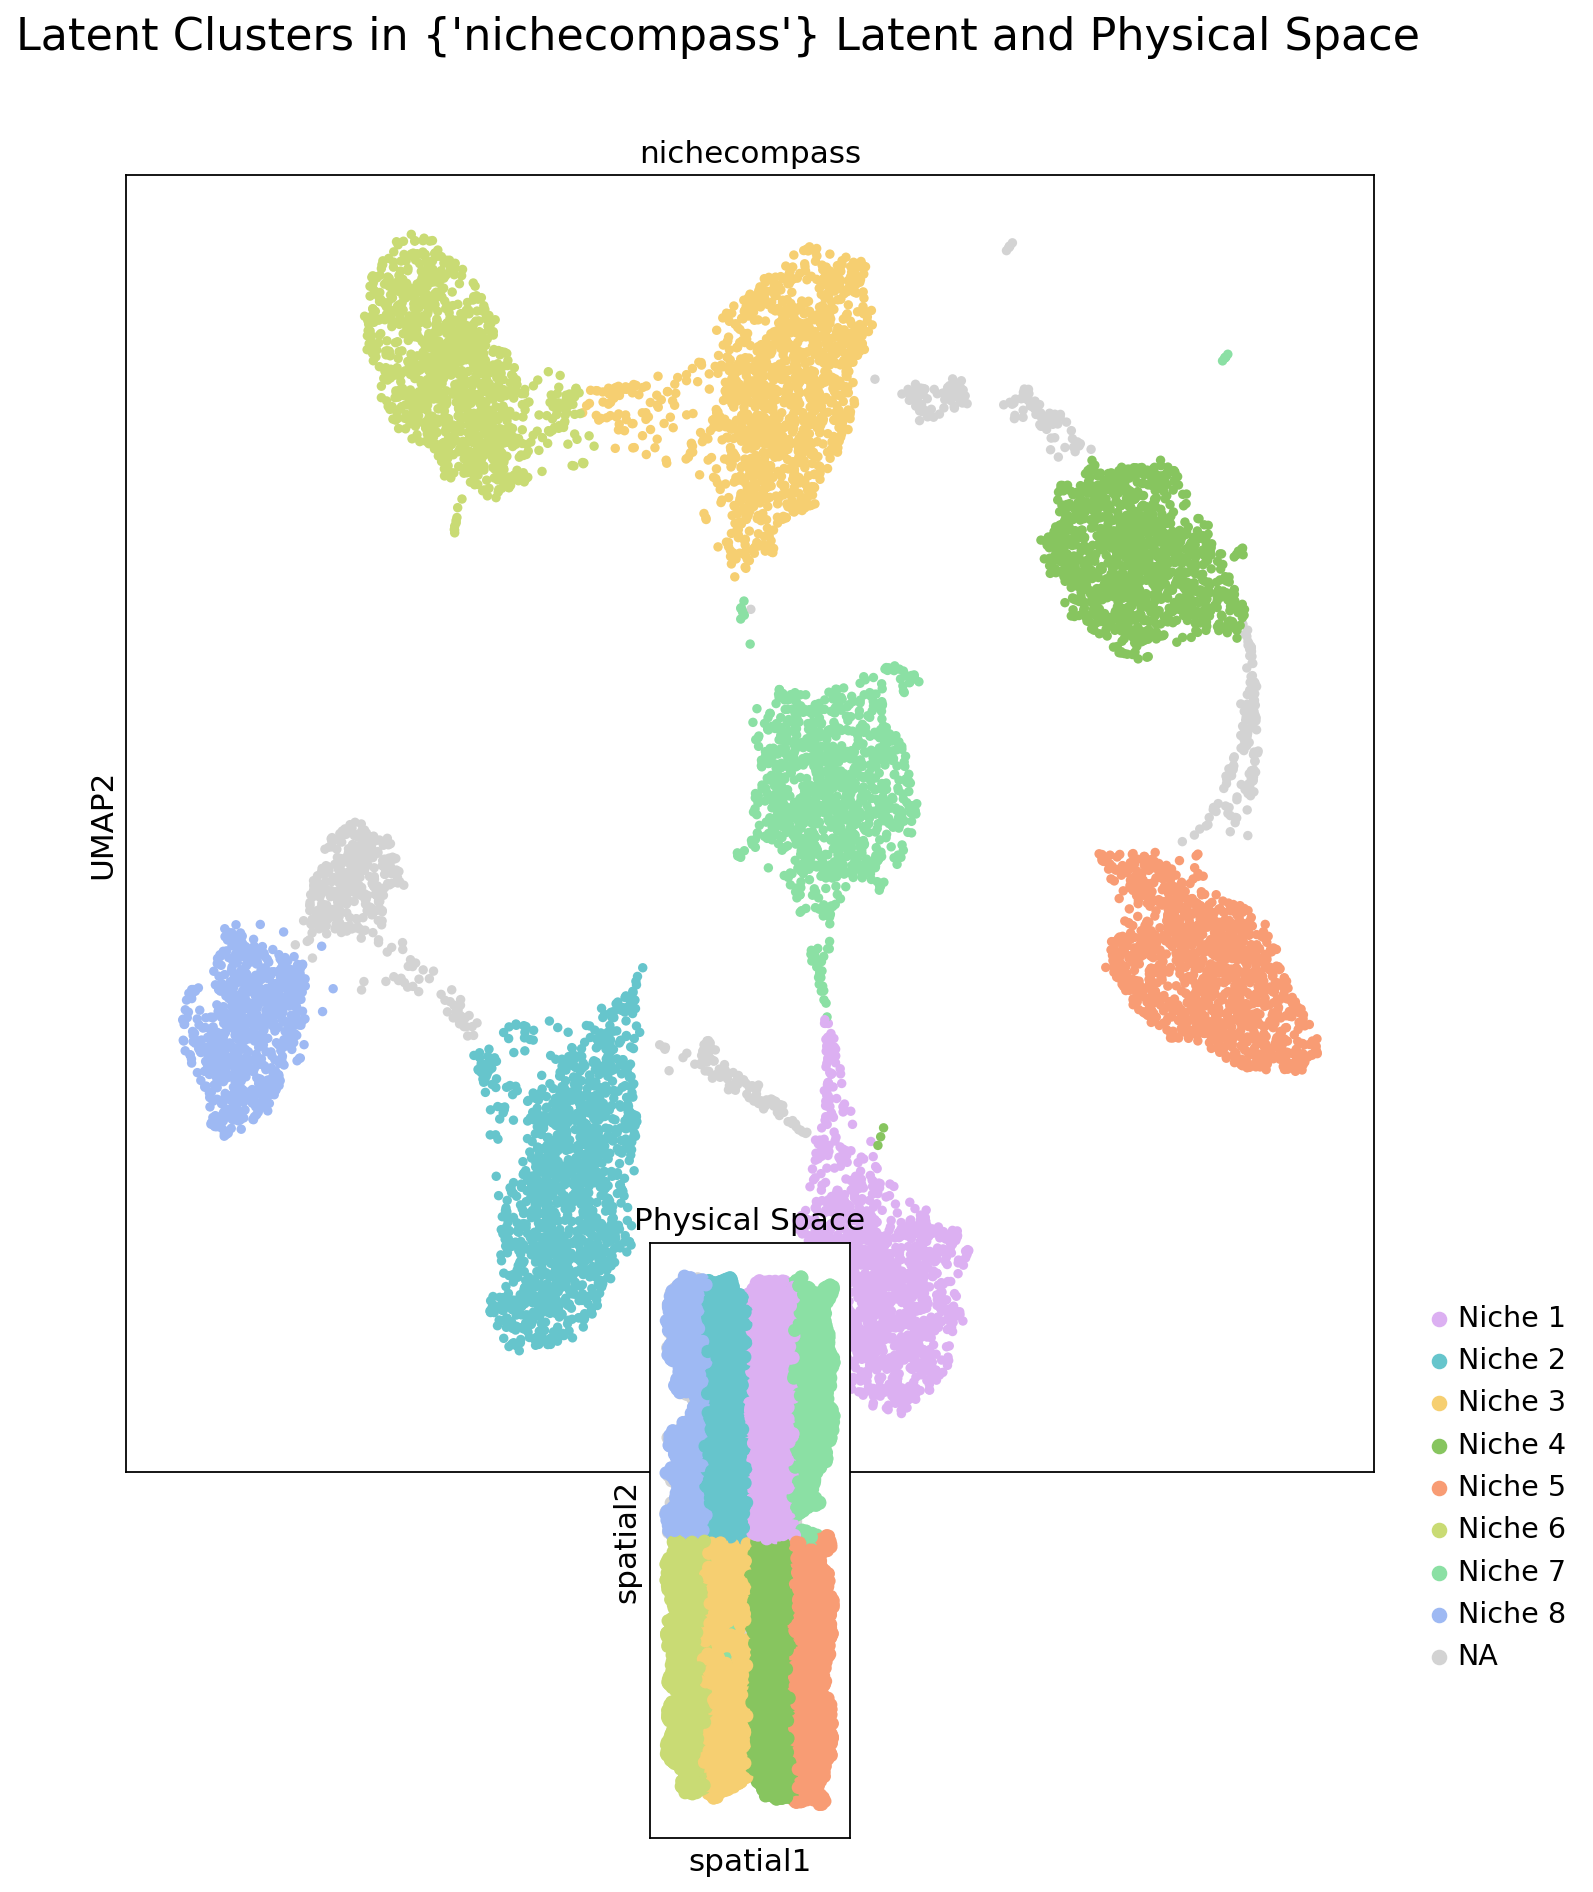

In [227]:
dataset = "sim1_1105genes_10000locs_strongincrements"
models = ["nichecompass_gatv2conv"]
run_number = 2
leiden_resolutions = [0.3]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    niche_annotations = {
        "0": "Niche 1",
        "1": "Niche 2",
        "2": "Niche 3",
        "3": "Niche 4",        
        "4": "Niche 5", 
        "5": "Niche 6", 
        "6": "Niche 7", 
        "7": "Niche 8"}

    adata.obs["niche"] = adata.obs[f"run{run_number}_leiden_{leiden_resolutions[0]}"].map(niche_annotations)

    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}")
    
    niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotations.items()}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            #figsize=(10, 20), for latent UMAP
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"niche",
            groups=None,
            sample_key="sample",
            samples=["sample1"], # =None for latent UMAP
            cat_colors=niche_colors,
            size=(720000 / len(adata)),
            spot_size=100,
            save_fig=False,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}_{dataset}.svg")

#### 2.1.7 SDMBench Data

In [ ]:
# Load metrics
datasets = ["starmap_mouse_mpfc"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "staci",
          #"deeplinc",
          "graphst",
          "cellcharter",
          "banksy"
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_single_sample)):
        min_val = dataset_df[metric_cols_single_sample[i]].min()
        max_val = dataset_df[metric_cols_single_sample[i]].max()
        dataset_df[metric_cols_single_sample[i] + "_scaled"] = ((
            dataset_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))
        
    for i in range(len(sdm_bench_metric_cols)):
        min_val = dataset_df[sdm_bench_metric_cols[i]].min()
        max_val = dataset_df[sdm_bench_metric_cols[i]].max()
        dataset_df[sdm_bench_metric_cols[i] + "_scaled"] = ((
            dataset_df[sdm_bench_metric_cols[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
    
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[4:6]]
    
summary_df[category_cols_single_sample[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[0:2],
                                                        axis=1)
summary_df[category_cols_single_sample[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[2:4],
                                                        axis=1)
summary_df[category_cols_single_sample[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[4:6],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]],
                                         weights=category_col_weights_single_sample[:3],
                                         axis=1)
summary_df["Ground Truth Prediction Score"] = np.average(summary_df[sdm_bench_metric_cols],
                                                         weights=sdm_bench_metric_col_weights,
                                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "cellcharter": "CellCharter",
                    "banksy": "BANKSY"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample + ["Overall Score"] + sdm_bench_metric_cols + ["Ground Truth Prediction Score"]].reset_index()

unrolled_df = pd.melt(
    aggregate_df, 
    id_vars=group_cols,
    value_vars=metric_cols_single_sample + ["Overall Score"] + sdm_bench_metric_cols + ["Ground Truth Prediction Score"],
    var_name="score_type", 
    value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "CellCharter"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

In [ ]:
dataset = "starmap_mouse_mpfc"

# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.6,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample], # category_col_titles_single_sample
    metric_col_width=0.5, # 0.8,
    aggregate_col_width=1.2,
    plot_width=10, # 8.5, # 32,
    plot_height=7,# 8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_{dataset}.svg")

In [ ]:
dataset = "starmap_mouse_mpfc"

# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.6,
    group_col="dataset",
    metric_cols=sdm_bench_metric_cols, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=sdm_bench_metric_col_weights, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=sdm_bench_metric_col_titles, # category_col_titles_single_sample
    metric_col_width=0.5, # 0.8,
    aggregate_col_width=1.2,
    plot_width=6.5, # 8.5, # 32,
    plot_height=7,# 8,
    overall_score_col="Ground Truth Prediction Score",
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_ground_truth_{dataset}.svg")

In [ ]:
# Load metrics
datasets = ["stereoseq_mouse_embryo"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          #"staci",
          #"deeplinc",
          "graphst",
          "cellcharter",
          "banksy"
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.DataFrame()
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            dataset_df = pd.concat([dataset_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            dataset_df = pd.concat([dataset_df, missing_run_df], ignore_index=True)
            
    # Apply min-max scaling to metric columns
    for i in range(len(metric_cols_single_sample)):
        min_val = dataset_df[metric_cols_single_sample[i]].min()
        max_val = dataset_df[metric_cols_single_sample[i]].max()
        dataset_df[metric_cols_single_sample[i] + "_scaled"] = ((
            dataset_df[metric_cols_single_sample[i]] - min_val) / (max_val - min_val))
        
    for i in range(len(sdm_bench_metric_cols)):
        min_val = dataset_df[sdm_bench_metric_cols[i]].min()
        max_val = dataset_df[sdm_bench_metric_cols[i]].max()
        dataset_df[sdm_bench_metric_cols[i] + "_scaled"] = ((
            dataset_df[sdm_bench_metric_cols[i]] - min_val) / (max_val - min_val))

    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    continue
    
cat_0_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[0:2]]
cat_1_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[2:4]]
cat_2_scaled_metric_cols = [metric_col + "_scaled" for metric_col in metric_cols_single_sample[4:6]]
    
summary_df[category_cols_single_sample[0]] = np.average(summary_df[cat_0_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[0:2],
                                                        axis=1)
summary_df[category_cols_single_sample[1]] = np.average(summary_df[cat_1_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[2:4],
                                                        axis=1)
summary_df[category_cols_single_sample[2]] = np.average(summary_df[cat_2_scaled_metric_cols],
                                                        weights=metric_col_weights_single_sample[4:6],
                                                        axis=1)
summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]],
                                         weights=category_col_weights_single_sample[:3],
                                         axis=1)
summary_df["Ground Truth Prediction Score"] = np.average(summary_df[sdm_bench_metric_cols],
                                                         weights=sdm_bench_metric_col_weights,
                                                         axis=1)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "staci": "STACI",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "cellcharter": "CellCharter",
                    "banksy": "BANKSY"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample + ["Overall Score"] + sdm_bench_metric_cols + ["Ground Truth Prediction Score"]].reset_index()

unrolled_df = pd.melt(
    aggregate_df, 
    id_vars=group_cols,
    value_vars=metric_cols_single_sample + ["Overall Score"] + sdm_bench_metric_cols + ["Ground Truth Prediction Score"],
    var_name="score_type", 
    value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "CellCharter"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

In [ ]:
dataset = "stereoseq_mouse_embryo"

# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.6,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample], # category_col_titles_single_sample
    metric_col_width=0.5, # 0.8,
    aggregate_col_width=1.2,
    plot_width=10, # 8.5, # 32,
    plot_height=7,# 8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_{dataset}.svg")

In [ ]:
dataset = "stereoseq_mouse_embryo"

# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.6,
    group_col="dataset",
    metric_cols=sdm_bench_metric_cols, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=sdm_bench_metric_col_weights, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=sdm_bench_metric_col_titles, # category_col_titles_single_sample
    metric_col_width=0.5, # 0.8,
    aggregate_col_width=1.2,
    plot_width=6.5, # 8.5, # 32,
    plot_height=7,# 8,
    overall_score_col="Ground Truth Prediction Score",
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_ground_truth_{dataset}.svg")